In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split

---------------------

# Retrieving and Preprocess Data

Image size:  100


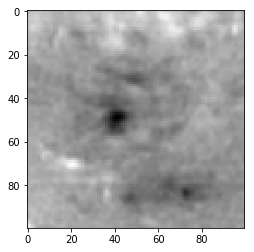

In [2]:
dataset = np.load('/home/kevinteng/Desktop/DeepLearning/Tensorflow2_0/test_npy/7-12-17-processed_dF.npy')
NEW_SIZE = 100
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
re_list = re_list.astype('float32')

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

(100, 100, 1) float32


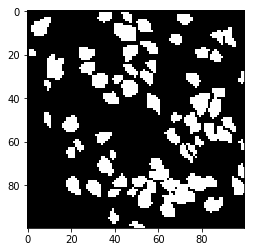

In [3]:
#retrieve and plot mean_ROI
mean_roi = np.load("/home/kevinteng/Desktop/Manual_Annotation/7-12-17_ROImask.npy")
mean_roi = cv2.resize(mean_roi, (NEW_SIZE, NEW_SIZE))
#Dimension for network should include the color channel 
mean_roi = np.expand_dims(mean_roi, axis = -1)
#Cast data type to float32 for TensorFlow
mean_roi = mean_roi.astype('float32')

print(mean_roi.shape, mean_roi.dtype)
plt.imshow(np.squeeze(mean_roi), cmap = 'gray')

In [4]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


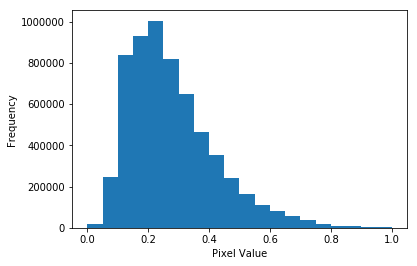

In [5]:
#plot historgram for min max norm image
plt.hist(re_list.ravel(),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Helper Function

In [6]:
# def gen_coord(number, IMG_SIZE):
#     coords_list = []
#     for i in range(number):
#         coords = [np.random.randint(0, IMG_SIZE),np.random.randint(0, IMG_SIZE)]
#         coords_list.append(coords)
#     coords_list = np.squeeze(np.asarray(coords_list)) #2d array of coordinates 
#     return coords_list

# def gen_onehot_img(coords_list, IMG_SIZE):
#     '''
#     Create one hot pixel images with given coordinate array
    
#     @param coords_list: coordinate arrays 
#     @IMG_SIZE: size of the image 
    
#     return a stack of onehot_imgs with shape (number of neurons, IMG_SIZE, IMG_SIZE, channel)
#     '''
#     onehot_imgs = []
#     xy_channels = []
#     for i in range(len(coords_list)):
#         onehot_img = np.zeros((IMG_SIZE, IMG_SIZE), dtype = np.float32)
#         onehot_img[coords_list[i,0],coords_list[i,1]] = 1.0
#         xy_channel = np.full((1, IMG_SIZE, IMG_SIZE, 2), coords_list[i])
#         onehot_imgs.append(onehot_img)
#         xy_channels.append(xy_channel)
        
#     onehot_imgs = np.squeeze(np.asarray(onehot_imgs)) #concatenate 
#     onehot_imgs_ = np.expand_dims(onehot_imgs, axis = 3) #expand a dim for channel
#     xy_channels = np.squeeze(np.asarray(xy_channels))
#     #swap axes s.t. the last channel would be the n_neurons
#     onehot_imgs_ = np.swapaxes(onehot_imgs_,0,-1).astype(np.float32)
#     xy_channels = np.swapaxes(xy_channels,0,-1).astype(np.float32)
    
#     return onehot_imgs_, xy_channels

def gen_coord(number, IMG_SIZE):
    coords_list = tf.cast(tf.random.uniform([number, 2],0, IMG_SIZE, dtype = tf.int64), dtype = tf.float32)
    return coords_list


def gen_onehot_img(coords_list, IMG_SIZE, n_neurons):
    '''
    Create one hot pixel images with given coordinate array
    
    @param coords_list: coordinate arrays 
    @IMG_SIZE: size of the image 
    
    return a stack of onehot_imgs with shape (number of neurons, IMG_SIZE, IMG_SIZE, channel)
    '''
    onehot_imgs = tf.TensorArray(tf.float32, size = n_neurons)
    for i, coords in enumerate(coords_list):
        onehot_img = np.zeros((IMG_SIZE, IMG_SIZE), dtype = np.float32)
        onehot_img[coords[0],coords[1]] = 1.0
        onehot_imgs.write(i, onehot_img)
    onehot_imgs = onehot_imgs.stack()
    onehot_imgs_ = tf.expand_dims(onehot_imgs, axis = 3) #expand a dim for channel
    #swap axes s.t. the last channel would be the n_neurons
    onehot_imgs_ = tf.transpose(onehot_imgs_,[3,1,2,0])
    
    return onehot_imgs_

def gen_onehot_img02(coords_list, IMG_SIZE, BATCH_SIZE):
    '''
    Create one hot pixel images with given coordinate array
    
    @param coords_list: coordinate arrays 
    @IMG_SIZE: size of the image 
    
    return a stack of onehot_imgs with shape (batch_size, IMG_SIZE, IMG_SIZE, channel)
    '''
    onehot_imgs = []
    for i in range(len(coords_list)):
        onehot_img = np.zeros((IMG_SIZE, IMG_SIZE), dtype = np.float32)
        onehot_img[coords_list[i,0],coords_list[i,1]] = 1.0
        onehot_imgs.append(onehot_img)
        
    onehot_imgs = np.squeeze(np.asarray(onehot_imgs)) #concatenate 
    onehot_imgs_ = np.expand_dims(onehot_imgs, axis = 3) #expand a dim for channel
    #swap axes s.t. the last channel would be the n_neurons
    onehot_imgs_ = np.swapaxes(onehot_imgs_,0,-1).astype(np.float32)
    #copy the same one hot images along the 0 axis, which is the number of batch size
    if (coords_list.ndim!=3):
        onehot_imgs_ = np.tile(onehot_imgs_, (BATCH_SIZE,1,1,1)) 
    return onehot_imgs_

In [7]:
coords_list = gen_coord(80, IMG_SIZE)

In [8]:
onehot_imgs = gen_onehot_img(coords_list, IMG_SIZE, 80)

In [9]:
print(onehot_imgs.shape)

(1, 100, 100, 80)


Coordinates: [46. 98.]


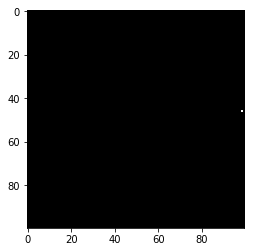

In [10]:
for i in range(len(onehot_imgs)):
    plt.imshow(np.squeeze(onehot_imgs[:,:,:,i]), cmap = 'gray')
    print("Coordinates: {}".format(coords_list[i]))
    plt.show()
    break

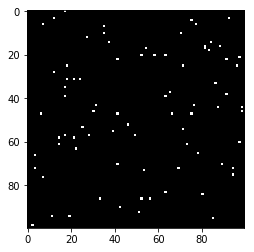

In [11]:
plt.imshow(np.sum(np.squeeze(onehot_imgs), axis = -1), cmap = 'gray')

-----------------------------------

# Model

In [12]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block

#build network
def coord_conv(input_layer, n_neurons):
    conv_01 = conv_block(input_layer, filters = 32, kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',batch_norm = True)
    coordconv_01 = coordconv_block(conv_01, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                    filters = n_neurons, kernel_size = 3, strides = 1, 
                                   padding='same', activation='sigmoid', batch_norm = True)
    
    return coordconv_01
        
    
def coord_regression(input_tensor): 
    x = CoordConv(x_dim = IMG_SIZE, y_dim = IMG_SIZE, with_r = False, filters = 20, 
              kernel_size = 1, activation=None)(input_tensor)
    x = Conv2D(20,1, activation = None)(x) 
    x = Conv2D(20,1, activation = None)(x)
    x = Conv2D(20,1, activation = None)(x) 
    x = Conv2D(20,1, activation = None)(x) 
    x = Conv2D(20,1, activation = None)(x)
    x = Conv2D(20,3, activation = None)(x) 
    x = Conv2D(2,3 ,activation = None)(x) 
    x = MaxPooling2D( pool_size=196, strides=196, padding='valid')(x)

    return x 

def latent_space(coords_list, scalars_list):
    return tf.concat((coords_list, scalar_list), axis = 1)

def decoder(latent_dim):
#     flat = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(latent_dim)
    dense_02 = Reshape((25,25,32))(dense_01)
    up_01 = up_block(dense_02, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 64, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    up_03 = up_block(up_02, up_size = 2, filters = 129, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    if(IMG_SIZE==100):
        output = coordconv_block(up_02, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                  filters = 1, kernel_size = 3, strides = 1,
                                  padding = 'same', activation = None)
    else:
        output = coordconv_block(up_03, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                          filters = 1, kernel_size = 3, strides = 1,
                          padding = 'same', activation = None)
    return output

## Build Model

In [13]:
n_neurons = 80
latent_n = (n_neurons*3*1)
input_layer = Input(shape = (IMG_SIZE, IMG_SIZE, 1))
latent_dim = Input(shape=(latent_n,))

coordConv = Model(input_layer, coord_conv(input_layer, n_neurons))
# coordReg = Model(input_layer, coord_regression(input_layer))
decode = Model(latent_dim, decoder(latent_dim))

varis = coordConv.trainable_variables + decode.trainable_variables

-----------------------------------------------------------------

In [14]:
decode.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240)]             0         
_________________________________________________________________
dense (Dense)                (None, 20000)             4820000   
_________________________________________________________________
reshape (Reshape)            (None, 25, 25, 32)        0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 100, 100, 32)      0   

## Train Model

In [15]:
# batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(1)
# for step, (img_batch) in enumerate(batch_imgs):
#     scalar_list = []
#     encoder = coordConv(img_batch)
#     if(step == 0):
#         coords_list = gen_coord(n_neurons, IMG_SIZE)
#     onehot_imgs, _ = gen_onehot_img(coords_list, IMG_SIZE)
#     for i in range(n_neurons):
#         tensor_dot = tf.tensordot(encoder[:,:,:,i], onehot_imgs[:,:,:,i], axes = [[1,2],[1,2]])
#         scalar_list.append(tensor_dot)
#     scalar_arr = tf.squeeze(np.asarray(scalar_list))
#     scalar_arr = tf.reshape(scalar_arr,(n_neurons,1))
#     tensor_mul = tf.cast(tf.math.round(scalar_arr*coords_list), dtype = tf.int64)
#     coords_list = tensor_mul
#     latent_rep = tf.concat((tf.cast(tensor_mul, dtype = tf.float32), scalar_arr), axis= -1)
#     #extend latent_rep channel 
#     latent_rep = tf.reshape(latent_rep,[1,-1])
#     decoded = decode(latent_rep)
#     break

In [16]:
# batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(1)
# for step, (img_batch) in enumerate(batch_imgs):
#     scalar_list = tf.TensorArray(tf.float32, size = n_neurons)
#     encoder = coordConv(img_batch)
#     if(step == 0):
#         coords_list = gen_coord(n_neurons, IMG_SIZE)
#     onehot_imgs = gen_onehot_img(coords_list, IMG_SIZE, n_neurons)
#     for i in tf.range(n_neurons):
#         tensor_dot = tf.tensordot(encoder[:,:,:,i], onehot_imgs[:,:,:,i], axes = [[1,2],[1,2]])
#         scalar_list.write(i, tensor_dot)
#     scalar_list = scalar_list.stack()
#     scalar_arr = tf.reshape(scalar_list,(n_neurons,1))
#     tensor_mul = tf.cast(tf.math.round(scalar_arr*coords_list), dtype = tf.int64)
#     coords_list = tensor_mul
#     latent_rep = tf.concat((tf.cast(tensor_mul, dtype = tf.float32), scalar_arr), axis= -1)
#     #extend latent_rep channel 
#     latent_rep = tf.reshape(latent_rep,[1,-1])
#     decoded = decode(latent_rep)
#     break

In [17]:
# latent_rep.shape

In [18]:
# scalar_arr.shape

In [19]:
# scalar_tst = tf.squeeze(scalar_arr)
# tensor_mul02 = tf.cast(tf.math.round(scalar_arr* tf.cast(coords_list, dtype = tf.float32)), dtype = tf.int64)

In [20]:
# #swap axis such that =>(batch_size, n_neurons, channel)
# scalar_arr = tf.reshape(scalar_arr,(n_neurons,1))
# print(scalar_arr.shape)

In [21]:
# tensor_mul = tf.cast(tf.math.round(scalar_arr*coords_list), dtype = tf.int64)

In [22]:
# tensor_mul.shape
# onehot_imgs, _ = gen_onehot_img(tensor_mul, IMG_SIZE)
# #need to cast the multiplication from int64 to float32 for concat
# latent = tf.concat((tf.cast(tensor_mul, dtype = tf.float32), scalar_arr), axis= -1)
# latent.shape

--------------------------------------

In [23]:
from utils_model import img_mean, min_max_norm, dice_coef_loss

#hyperparameter
BATCH_SIZE = 1
lr = 0.001
#loss function
loss_fn = tf.losses.MeanSquaredError()

#optimizer 
opt = tf.optimizers.Adam(lr)

batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE)

@tf.function
def train(batched_imgs, IMG_SIZE, steps):
    with tf.GradientTape() as tape:
        #declare empty scalar list for storing scalar values
        scalar_list = tf.TensorArray(tf.float32, size = n_neurons)
        #retrive output image from the coordconv architecture
        encoder = coordConv(batched_imgs)
        '''
        if(steps == 0):
            coords_list = gen_coord(n_neurons, IMG_SIZE)
        '''
        #generate random coordinates
        coords_list = gen_coord(n_neurons, IMG_SIZE)
        #generate one hot images from the coordinates
        onehot_imgs = gen_onehot_img(coords_list, IMG_SIZE, n_neurons)
        #dot product to achieve scalar
        for i in tf.range(n_neurons):
            tensor_dot = tf.tensordot(encoder[:,:,:,i], onehot_imgs[:,:,:,i], axes = [[1,2],[1,2]])
            scalar_list.write(i, tensor_dot)
        #stacking the scalar values shape(80)
        scalar_list = scalar_list.stack()
        #reshape scalar value tensor to (80,1) for tensor multiplication
        scalar_arr = tf.reshape(scalar_list,(n_neurons,1))
        #tensor_mul => shape(80,2)
        tensor_mul = tf.cast(tf.math.round(scalar_arr*coords_list), dtype = tf.int64)
#         coords_list = tensor_mul
        #formulation of latent space
        latent_rep = tf.concat((tf.cast(tensor_mul, dtype = tf.float32), scalar_arr), axis= -1)
        #flatten and extend latent_rep channel  
        latent_rep = tf.reshape(latent_rep,[1,-1])
        #upsampling and decode => reconstruction
        decoded = decode(latent_rep)
        #comparison with the original image
        xent = loss_fn(batched_imgs, decoded)
        
    grads = tape.gradient(xent, varis)
    opt.apply_gradients(zip(grads, varis))
    
    return xent, coords_list, grads

coordinates = []
loss_list = [] #loss list

epochs = 0

# batch_imgs = utils.batch_dataset(re_list, BATCH_SIZE, IMG_SIZE)

while epochs < 30:
    for steps, batched_imgs in enumerate(batch_imgs):
        xent, coords_list, grads =train(batched_imgs, IMG_SIZE, steps)
        coordinates.append(coords_list)
        loss_list.append(xent)
        
    print("Epochs {:2d}, Loss: {}".format(epochs, xent.numpy()))
    print("Gradient min:{}, max:{}".format(np.min(grads[0]), np.max(grads[0])))
    print()
    epochs+=1

TypeError: Tensor objects are only iterable when eager execution is enabled. To iterate over this tensor use tf.map_fn.

In [ ]:
#plot for mean image of last 10 steps w.r.t mean roi 
last_n_steps = 5
for i in range(last_n_steps):
    max_image = de_list[len(de_list) - last_n_steps + i]
    max_image = np.asarray(max_image) #cast tf object into np array
    masked_image = masked_img(max_image, mean_roi)
    
    #plot
    inp_imgs = [max_image , mean_roi, masked_image]
    captions = ['Prediction',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions,n_col = 3, figsize = (10,10))
    
    print('Loss:', loss_list[len(de_list) - last_n_steps + i].numpy())
    print('Dice coefficient: ', dice_coef_py(mean_roi, max_image))

In [ ]:
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list, xlabel, ylabel, title)

-------------------------------------------------

# Predict

In [ ]:
sums = 0
slices = 20 #slices of image from image stack 
n = 5

#create data generator for test set
ds_test = tf.data.Dataset.from_tensor_slices(re_list).batch(slices)

for i, (test_batch) in enumerate(ds_test):
    assert test_batch.shape[0] == slices

    conv_img = model(test_batch)
    max_img = tf.reduce_max(conv_img,0)
    max_img = min_max_norm(max_img)

    max_image = np.asarray(max_img) #cast tf object into np array
    masked_image = masked_img(max_image, mean_roi)
    inp_imgs = [np.squeeze(max_image), mean_roi, masked_image]

    captions = ['Predictions',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions, n_col = 3,figsize = (10,10))

    print('MSE for predicted image: ', MSE_image(max_img, mean_roi, IMG_SIZE))
    print('Dice coefficient: ', dice_coef_py(mean_roi, max_image))
    
    sums+=1

    #plot only n images for prediction
    if sums == n:
        break

-----------------------------------------------

# Visualizing Feature Maps

In [ ]:
from utils_vis import layers_dict, feature_maps, plot_feature_maps, layers_name

layer_dict = layers_dict(model)
layer_name = layers_name(model)

In [ ]:
if coordconv:
    layer_name = 'coord_conv'
else:
    layer_name = 'conv2d'
    
# layer_output = layer_dict[layer_name].output

In [ ]:
# taking the mean over all stacks as input
test_img = np.asarray(tf.expand_dims(max_img_ori, 0)) #(1, img size, img size, 1)
#test_img = tf.expand_dims(test_img, -1) #(1, img size, img size, 1)
plt.imshow(np.squeeze(test_img), cmap = 'gray')
plt.show()

## Visualizing Last Layer of Feature Maps

In [ ]:
# test_map = feature_maps(model, '{}_3'.format(layer_name), test_img)
# plot_feature_maps(test_map, 8, 8, figsize = (20,20))

## Visualizing First Layer of Feature Maps

In [ ]:
# test_map02 = feature_maps(model, '{}_1'.format(layer_name), test_img)
# plot_feature_maps(test_map02, 4, 8, figsize = (20,20))

--------------------------------

# Appendix

In [ ]:
model.summary()